In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from random import randrange

# Data for final consumption and total output

## Final consumption

In [49]:
fdata = pd.read_csv('fdata_esp.csv', sep = ',')
fdata.head()

,Unnamed: 0,f,fmin,fmax,f.maxF,f.maxX
0,A01,22067.825137,0,19878.183746,1.987818e+04,19878.183746
1,A02,491.390952,0,449.053800,3.435896e-11,0.000000
2,A03,2136.674970,0,1923.204924,1.923205e+03,1923.204924
3,B,7537.433840,0,6785.237797,3.846149e+03,3845.767925
4,C10-C12,77720.433660,0,69972.411738,5.427950e-09,9006.175456


In [3]:
f = fdata.iloc[:,1].astype('float')
f_max = np.array(fdata.iloc[:,3].astype('float'))

## Total output

In [5]:
xdata =  pd.read_csv('xdata_esp.csv', sep = ',')
xdata.head()   

,Unnamed: 0,x,xmin,xmax,x.maxF,x.maxX
0,A01,55296.202212,0,55296.202212,26979.266525,29126.656345
1,A02,1280.146466,0,192.023581,192.023581,192.023581
2,A03,3627.285823,0,3627.285823,2320.350569,2381.333167
3,B,8061.338000,0,4166.069492,4166.069492,4166.069492
4,C10-C12,177754.573395,0,131603.349214,27951.943564,41389.199799


In [6]:
x = xdata.iloc[:,1].astype('float')
x_max = np.array(xdata.iloc[:,3].astype('float'))

In [7]:
supply_shock = np.zeros(x_max.shape[0])
for i in range (0,x_max.shape[0]):
    supply_shock[i] = round(1- x_max[i]/x[i],6)
    
print(supply_shock) # ok: corresonds to the data 

[0.       0.849999 0.       0.483204 0.259635 0.685309 0.730686 0.
 0.       0.064001 0.525183 0.       0.705058 0.639448 0.726353 0.662572
 0.430758 0.630639 0.618354 0.696668 0.597033 0.596618 0.606449 0.058407
 0.       0.       0.715557 0.27312  0.299699 0.256656 0.       0.
 0.242194 0.       0.       0.646411 0.07561  0.109813 0.       0.144301
 0.       0.       0.       0.512768 0.181406 0.459166 0.410839 0.396788
 0.19581  0.543278 0.       0.460076 0.       0.559507 0.      ]


In [8]:
supply_shock = np.array(supply_shock)

# IO table 

In [9]:
df = pd.read_csv('esp_wiot.csv',sep = ',',low_memory=False)
df.head()

,Unnamed: 0,A01,A02,A03,B,C10-C12,C13-C15,C16,C17,C18,...,M71,M72,M73,M74_M75,N,O84,P85,Q,R_S,T
0,A01,0.036044,0.005051,0.004090,1.829061e-04,0.154009,0.020155,4.271070e-04,0.002918,3.278248e-04,...,2.067310e-04,0.000593,2.223937e-04,2.182217e-04,4.122063e-04,0.000796,0.000661,0.000947,0.002079,0
1,A02,0.000224,0.036896,0.000007,1.489546e-04,0.000306,0.000041,2.178111e-02,0.023392,3.250353e-07,...,5.292217e-07,0.000004,4.415084e-07,7.452870e-07,8.399119e-07,0.000003,0.000001,0.000001,0.000005,0
2,A03,0.000780,0.000000,0.023371,9.294775e-07,0.004311,0.000101,2.354406e-07,0.000064,0.000000e+00,...,3.279189e-07,0.000019,0.000000e+00,0.000000e+00,0.000000e+00,0.000081,0.000250,0.000251,0.000030,0
3,B,0.000066,0.000050,0.000099,1.667939e-04,0.000065,0.000106,1.365677e-04,0.000126,6.687052e-05,...,2.391449e-04,0.000050,5.490456e-05,4.593785e-05,2.998228e-05,0.000034,0.000016,0.000056,0.000027,0
4,C10-C12,0.217493,0.001697,0.070624,3.893840e-03,0.296567,0.030230,5.516487e-03,0.020444,5.226470e-03,...,3.152230e-03,0.004704,3.921158e-03,1.320034e-02,3.923160e-03,0.006022,0.006058,0.012565,0.008250,0


In [10]:
df = df.iloc[:,1:]
df = df.astype('float')
df.shape

(55, 55)

In [11]:
A = np.array(df)
N = A.shape[0]
A.shape

(55, 55)

## Matrix Z

In [12]:
df_Z = pd.read_csv('esp_Zmatrix.csv', sep=',', low_memory=False)
df_Z =  df_Z.iloc[:,1:]# leaving out industries U and T
df_Z = df_Z.astype('float')
df_Z.shape

(55, 55)

In [13]:
Z = np.array(df_Z)
N = Z.shape[0]
Z.shape

(55, 55)

In [14]:
x_0 = np.array(x)
x_0.shape

(55,)

In [15]:
f_0 = np.array(f)
f_0.shape

(55,)

In [16]:
L = np.linalg.inv(np.identity(N)-A)
L.shape

(55, 55)

# Optimization 

In [19]:
def max_output(N,L,A,xmax,fmax):
    z = np.ones(N)
    obj = -np.matmul(np.matrix.transpose(z), L)
    lhs_ineq = np.concatenate((-L,L))
    rhs_ineq = np.concatenate((np.zeros(N), xmax))
    
    bnd = []
    for i in range (0,N):
        bnd.append((0,fmax[i]))
    
    result = linprog(c = obj, A_ub= lhs_ineq, b_ub= rhs_ineq, bounds = bnd)
    
    optimal_output = -result.fun
    
    optimal_f = np.ones(N)
    for i in range(0,N):
        optimal_f[i] = result.x[i]
    
    return optimal_output, optimal_output/sum(x_0), sum(optimal_f)/sum(f_0)

In [21]:
def max_consumption(N,L,A,xmax,fmax):
    z = np.ones(N)
    obj2 = -np.matmul(np.matrix.transpose(z), np.identity(N)-A)
    lhs_ineq2 = np.concatenate((-(np.identity(N)-A), np.identity(N)-A))
    rhs_ineq2 = np.concatenate((np.zeros(N), fmax))
    
    bnd2 = []
    for i in range (0,N):
        bnd2.append((0,xmax[i]))
        
    result2 = linprog(c = obj2, A_ub= lhs_ineq2, b_ub= rhs_ineq2, bounds= bnd2)
    optimal_f_2 = -result2.fun
    
    optimal_output_2 = np.ones(N)
    for i in range(0,N):
        optimal_output_2[i] = round(result2.x[i])
        
    return result2.success, sum(optimal_output_2)/sum(x_0), optimal_f_2/sum(f_0)

In [23]:
N= 54
f_max = f_max[:N]
x_max = x_max[:N]
A = A[:N,:N]
Z = Z[:N,:N]
x_0 = x_0[:N]
f_0 = f_0[:N]
L = np.linalg.inv(np.identity(N)-A)
supply_shock = np.array(supply_shock[:N])
demand_shock = np.array(demand_shock[:N])

In [29]:
def algo_proportional(A, L, fmax, xmax, TT, prioritize="no"):
    x = [0]
    fvec = []          # initial demand vector
    fvec.append(fmax)
    r = [0]            # output constraints
    s = [0]            # input bottlenecks 
    d = [0]            # aggregated demand vector 
    d.append(np.matmul(L, fvec[0])) #d[1] = L*f[0]

    list_ = [1] 
    t=1
    epsilon = 1e-6
    while not np.all(abs(d[t] - d[t-1]) < epsilon) and t<TT:
        #print('\nIteration {0}'.format(t))
        #print('---------')
        #print('Initial aggregated demand: {}'.format(d[t]))
        r.append(np.ones(len(xmax)))
        s.append(np.ones(len(xmax)))
        fvec.append(np.ones(len(xmax)))
        x.append(np.ones(len(xmax)))
        d.append(np.ones(len(xmax)))
        
        ##########################################
        ########### Output constraints ###########
        ##########################################
        for i in range (0,len(x_max)):
            r[t][i] = xmax[i]/d[t][i]
        #print('Output constraints:{}'.format(r[t]))
        
        ##########################################
        ########### Input bottlenecks ############
        ##########################################
        for i in range(0,len(x_max)):
            for j in range(0,len(x_max)):
                if A[j][i] > 0:
                    list_.append(r[t][j])
            s[t][i] = min(list_)
            list_ = [1]
        #print('Input bottlenecks:{}'.format(s[t]))
        
        ##############################################
        ########### Constrained Production ###########
        ##############################################
        for i in range(0,len(xmax)):
            x[t][i] = min(xmax[i], s[t][i]*d[t][i])
        #print('Constrained production:{}'.format(x[t]))
        
        ##############################################
        ############ Constrained Delivery ############
        ##############################################
        for i in range(0,len(xmax)):
            fvec[t][i] = max(x[t][i] - np.matmul(A[i],x[t]),0)
        #print('Constrained delivery:{}'.format(fvec[t]))
        
        ###############################################
        ############ New Aggregated Demand ############
        ###############################################
        for i in range(0,len(xmax)):
            d[t+1][i] = np.matmul(L[i],fvec[t])
        t=t+1
        #print('Aggregated Demand:         {}'.format(d[t]))
        if t == TT:
            print("Algoritm did not converge")
            
    return sum(x[t-1]), sum(x[t-1])/sum(x_0), sum(fvec[t-1])/sum(f_0), t


In [30]:
def algo_mixed(A, L, fmax, xmax, TT,prioritize="yes"):
    x = [0]
    #fout = [0]
    fvec = [] # initial demand vector
    fvec.append(fmax)
    r = [0]   # output constraints
    s = [0]   # input bottlenecks 
    d = [0]   # aggregated demand vector 
    d.append(np.matmul(L, fvec[0])) #d[1] = L*f[0]
    
    list_ = [1] 
    t=1
    epsilon = 1e-6
    while not np.all(abs(d[t] - d[t-1]) < epsilon) and t<TT:
        #print('\nIteration {0}'.format(t))
        #print('---------')
        #print('Initial aggregated demand: {}'.format(d[t]))
        r.append(np.ones(len(xmax)))
        s.append(np.ones(len(xmax)))
        fvec.append(np.ones(len(xmax)))
        x.append(np.ones(len(xmax)))
        d.append(np.ones(len(xmax)))
        #fout.append(np.ones(len(xmax)))
        
        ##########################################
        ########### Output constraints ###########
        ##########################################
        for i in range (0,len(x_max)):
            r[t][i] = xmax[i]/np.matmul(A[i],d[t])
        #print('Output constraints:         {}'.format(r[t]))
        
        ##########################################
        ########### Input bottlenecks ############
        ##########################################
        for i in range(0,len(x_max)):
            for j in range(0,len(x_max)):
                if A[j][i] > 0:
                    list_.append(r[t][j])
            s[t][i] = min(list_)
            list_ = [1]
        #print('Input bottlenecks:         {}'.format(s[t]))
        
        ##############################################
        ########### Constrained Production ###########
        ##############################################
        for i in range(0,len(xmax)):
            x[t][i] = min(xmax[i], s[t][i]*d[t][i])
            #print(s[t][i]*d[t][i])
        
        ##############################################
        ############ Constrained Delivery ############
        ##############################################
        
       # for i in range(0,len(xmax)):
            #fout[t][i] = s[t][i]*d[t][i]
            #print(s[t][i]*d[t][i])
        
        for i in range(0,len(xmax)):
            #print(np.matmul(A[i],s[t]*d[t]))
            fvec[t][i] = max(x[t][i] - np.matmul(A[i],x[t]),0) 
        #print('Constrained delivery:      {}'.format(fvec[t]))
        
        ###############################################
        ############ New Aggregated Demand ############
        ###############################################
        for i in range(0,len(xmax)):
            d[t+1][i] = np.matmul(L[i],fvec[t])
        t=t+1
    
    if t == TT:
        print("Algoritm did not converge")
        
    return sum(x[t-1]), sum(x[t-1])/sum(x_0), sum(fvec[t-1])/sum(f_0), t

In [31]:
def order(A, L, fmax):
    d = np.matmul(L, fmax)
    list_1 = []      # list we will sort
    list_2 = []      # list that will not be sorted to find the original indices
    for i in range(A.shape[0]):
        list_1.append([])
        list_2.append([])
    for i in range(A.shape[0]):
        for j in range(A.shape[0]):
            list_1[i].append(A[i][j]*d[j])    # list_1[i][j] = list_2[i][j] = A[i][j]*d[j]
            list_2[i].append(A[i][j]*d[j])
        list_1[i].sort(reverse = True)        # we sort list_1: A[i][j]*d[j] >= A[i][j+1]*d[j+1]

    names_ordered=[]
    for i in range(A.shape[0]):
        names_ordered.append([])
    
    for i in range(A.shape[0]):
        for k in list_1[i]:                  # we take the indices of the j+1 (j from 0 to N-1) biggest suppliers of industry i. 
                for l in range(A.shape[0]):    
                    if list_2[i][l] == k:
                        names_ordered[i].append(l)   
    return names_ordered

In [32]:
def algo_priority(A, L, fmax, xmax, ordered, TT= 30, prioritize="yes"):                 
    x = [0]
    fvec = []   # initial demand vector
    fvec.append(fmax)
    rvec = [0]  # output constraints
    s = [0]     # input bottlenecks 
    d = [0]     # aggregated demand vector 
    d.append(np.matmul(L, fvec[0])) #d[1] = L*f[0]
    
    list_ = [1] 
    t=1
    epsilon = 1e-6
    
    while not np.all(abs(d[t] - d[t-1]) < epsilon) and t<TT:
        #print('\nIteration {0}'.format(t))
        #print('---------')
        #print('Initial aggregated demand: {}'.format(d[t]))
        rvec.append([np.zeros(N)])
        s.append(np.ones(N))
        fvec.append(np.ones(N))
        x.append(np.ones(N))
        d.append(np.ones(N))
        demand = np.identity(N)
        
        som = 0
        for i in range(0,N):
            for j in range(0,N):
                for k in ordered[i][:j+1]:
                    som = som + A[i][k]*d[t][k] 
                demand[i][j] = som   #demand[i][j] = demand of j'th biggest customers of firm i summed up
                som = 0
        remainder = np.identity(N)
    
        for i in range(0,N):
            for j in range(0,N):
                remainder[i][j] = xmax[i] - demand[i][j]
                
        ####################################################
        ####################### rvec #######################
        ####################################################
        for i in range(0,N):
            rvec[t].append([])
        for i in range(0,N):
            if all(remainder[i][j]>0 for j in range(0,N)):
                rvec[t][i] = np.ones(N) 
            elif all(remainder[i][j]<=0 for j in range(0,N)): 
                rvec[t][i] = np.zeros(N)
                for k in ordered[i][:1]: 
                    rvec[t][i][k] = xmax[i]/demand[i][0]
        
            else: 
                idx = np.where(remainder[i]<=0) # index for partially met demand
                idx_fully = np.where(remainder[i]>0) 
                length = len(idx_fully[0])
                rvec[t][i] = np.zeros(N)
                for l in range(0,length-1):
                    index = ordered[i][l]
                    rvec[t][i][index] = 1
                m = ordered[i][length-1]
                rvec[t][i][m] = remainder[i][length-1]/(demand[i][length]-demand[i][length-1])
          
        #####################################################
        ################# Input bottlenecks #################
        #####################################################
        for i in range(0,N):
            for j in range(0,N):
                if A[j][i]>0:
                    list_.append(rvec[t][j][i])
            s[t][i] = min(list_)
            list_ = [1]   
        #print('Input bottlenecks:         {}'.format(s[t]))
        
        ######################################################
        ############### Constrained Production ###############
        ######################################################
        for i in range(0,N):
            x[t][i] = min(xmax[i], s[t][i]*d[t][i])
        
        ######################################################
        ################ Constrained Delivery ################
        ######################################################
        for i in range(0,len(xmax)):
            fvec[t][i] = max(x[t][i] - np.matmul(A[i],x[t]),0)
        
        ######################################################
        ################ Aggregated demand ###################
        ######################################################
        for i in range(0,len(xmax)):
            d[t+1][i] = np.matmul(L[i],fvec[t])
            
        t=t+1
        if t==TT:
            print("Algorithm did not converge")
            #return(None, None)
        #print(d[t])
    return sum(x[t-1]), sum(x[t-1])/sum(x_0), sum(fvec[t-1])/sum(f_0), t

In [35]:
def algo_random(A, L, fmax, xmax, runs, prioritize = "random"):
    som_x = []
    x = []
    y = []
    TT = 30
    while len(x)<runs:
        random_ordered=[]
        for i in range(N):
            random_ordered.append([])
    
        for i in range(N):
            while len(random_ordered[i])<N:
                random = randrange(N)
                while random in random_ordered[i]:
                    random = randrange(N)# we willen nu de indices van de j+1 (j van 0 tot en met N-1) grootste suppliers  
                random_ordered[i].append(random)
                
        result = algo_priority(A, L, fmax, xmax, random_ordered, TT = 25, prioritize="yes")
        if result[3] != TT:
            som_x.append(result[0])
            #som_x = sum(som_x)/len(sum_x)
            x.append(result[1])
            y.append(result[2])
    return sum(som_x)/len(som_x), sum(x)/len(x), sum(y)/len(y)

# Effect Network Density

## Eliminate Random Links

In [36]:
def eliminate_rand(A, x, f, desired_density):
    Anew = A
    zeros = np.sum(Anew==0)
    Znew = Z
    indices_x = []
    indices_y = []
    if desired_density != 1:
        sparselink = round((N**2)*(1-desired_density) - np.sum(Anew==0)) # number of links we need to remove to get desired density
        print("Sparselink: {0}".format(sparselink))
        while(np.sum(Znew==0)) < sparselink + zeros: 
            random_x = randrange(N)
            random_y = randrange(N)
            while Znew[random_x,random_y] == 0:
                random_x = randrange(N)
                random_y = randrange(N)
            Znew[random_x, random_y] = 0
            
                
    xnew = np.sum(Znew, axis=1) + f
    for i in range(0,N):
        for j in range(0,N):
            Anew[i][j] = Znew[i][j]/x[j]
    Lnew = np.linalg.inv(np.identity(N)-Anew)
    #xnew = Znew + f
    
    return xnew, Anew, Lnew, Znew

### Direct shock

**For 50 different densities, we adapt our matrix. We compute xnew, Anew, xmaxnew. Then we apply the shocks to the new data: instead of sum(xmax)/sum(x) it is now equal to sum(xmaxnew)/sum(xnew).**

In [37]:
densseq = np.linspace(0,1,50)

In [38]:
resdir_x = np.identity(50)
densseq = np.linspace(0,1,50)
runs_dens = 50
for i in range(len(densseq)):
    for j in range(runs_dens):
        A = np.array(df)[:N,:N] 
        Z = np.array(df_Z)[:N,:N] 
        newdat = eliminate_rand(A, x_0, f_0, densseq[i])
        #print(densseq[i])
        xmaxnew = np.ones(N)
        for k in range(0,N):
            xmaxnew[k] = newdat[0][k]*(1- supply_shock[k])
        resdir_x[i][j] = (sum(xmaxnew)/sum(newdat[0]))
resdir_x = np.mean(resdir_x, axis = 1)

Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2840
Sparselink: 2840
Sparselink: 2840
Sparselink: 2840
Sparselink: 2840
Sparselink: 2840
Sparselink: 2840
Sparselink: 2840
Sparselink: 28

Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 23

Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 17

Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1115
Sparselink: 1115
Sparselink: 1115
Sparselink: 1115
Sparselink: 1115
Sparselink: 1115
Sparselink: 1115
Sparselink: 1115
Sparselink: 1115
Sparselink: 1115
Sparselink: 1115
Sparselink: 11

Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparseli

array([0.63671461, 0.63754358, 0.6389673 , 0.63933533, 0.639926  ,
       0.64143275, 0.64063857, 0.64314327, 0.64389726, 0.64488798,
       0.64530592, 0.64581085, 0.64696274, 0.64873541, 0.64756703,
       0.64820818, 0.64870638, 0.64908001, 0.65082654, 0.65071045,
       0.65242215, 0.65327756, 0.6527239 , 0.65393233, 0.65394781,
       0.65379376, 0.6541581 , 0.65545746, 0.65607376, 0.65849282,
       0.6570138 , 0.6572876 , 0.65790444, 0.66005654, 0.65827205,
       0.65975237, 0.65975585, 0.66115865, 0.66197742, 0.66034213,
       0.66183847, 0.66331419, 0.66304932, 0.66335038, 0.66348915,
       0.66416401, 0.66439434, 0.66510758, 0.66561066, 0.6655754 ])

## Optimization

In [ ]:
resmax_x = np.identity(50)
densseq = np.linspace(0,1,50)
runs_dens = 50
for i in range(len(densseq)):
    print("Iteration {0}" .format(i))
    for j in range(runs_dens):
        A = np.array(df)[:N,:N] 
        Z = np.array(df_Z)[:N,:N] 
        newdat = eliminate_rand(A, x_0, f_0, densseq[i])
        #print(densseq[i])
        xmaxnew = np.ones(N)
        for k in range(0,N):
            xmaxnew[k] = newdat[0][k]*(1- supply_shock[k])
        
        result = max_output(N,newdat[2],newdat[1],xmaxnew,f_max)
        resmax_x[i][j] = (result[0]/sum(newdat[0]))
resmax_x = np.mean(resmax_x, axis = 1)

## Proportional rationing

In [39]:
resprop_x = np.identity(50)
densseq = np.linspace(0,1,50)
runs_dens = 50
TT = 30
for i in range(len(densseq)):
    print("Iteration {0}".format(i))
    for j in range(runs_dens):
        A = np.array(df)[:N,:N] 
        Z = np.array(df_Z)[:N,:N] 
        newdat = eliminate_rand(A, x_0, f_0, densseq[i])
        #print(densseq[i])
        xmaxnew = np.ones(N)
        for k in range(0,N):
            xmaxnew[k] = newdat[0][k]*(1- supply_shock[k])
        
        result = algo_proportional(newdat[1], newdat[2], f_max, xmaxnew, TT, prioritize = "no")
        if result[3]!= 30:
            resprop_x[i][j] = (result[0]/sum(newdat[0]))
        else:
            resprop_x[i][j] = np.nan
resprop_x = np.mean(resprop_x, axis = 1)

Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2840
Sparselink: 2840
Sparselink: 2840
Sparselink: 2840
Sparselink: 2840
Sparselink: 2840
Sparselink: 2840
Sparselink: 2840
Sparselink: 28

Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 23

Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 17

Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1115
Sparselink: 1115
Sparselink: 1115
Sparselink: 1115
Sparselink: 1115
Sparselink: 1115
Sparselink: 1115
Sparselink: 1115
Sparselink: 1115
Sparselink: 1115
Sparselink: 1115
Sparselink: 1115
Sparselink: 1115
Sparselink: 11

Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparseli

## Priority

In [40]:
resprior_x = np.identity(50)
densseq = np.linspace(0,1,50)
runs_dens = 50
for i in range(len(densseq)):
    print("Iteration {0}".format(i))
    for j in range(runs_dens):
        A = np.array(df)[:N,:N] 
        Z = np.array(df_Z)[:N,:N] 
        newdat = eliminate_rand(A, x_0, f_0, densseq[i])
        #print(densseq[i])
        xmaxnew = np.ones(N)
        for k in range(0,N):
            xmaxnew[k] = newdat[0][k]*(1- supply_shock[k])
        names_ordered = order(newdat[1],newdat[2],f_max)
        
        result = algo_priority(newdat[1], newdat[2], f_max, xmaxnew, names_ordered,TT=30, prioritize="yes")
        if result[3] != 30:
            #result = algo_priority(newdat[1], newdat[2], f_max, xmaxnew, names_ordered,TT=30, prioritize="yes")
            resprior_x[i][j] = (result[0]/sum(newdat[0]))
        else:
            resprior_x[i][j] = np.nan
        
resprior_x = np.nanmean(resprior_x, axis = 1)

Iteration 0
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Iteration 1
Sparselink: 2840
Sparselink: 2840
Sparselink: 2840
Sparselink: 2840
Sparselink: 2840
Sparselink: 2840
Sparselink: 2840
Sparsel

Sparselink: 2424
Sparselink: 2424
Sparselink: 2424
Sparselink: 2424
Algorithm did not converge
Sparselink: 2424
Sparselink: 2424
Sparselink: 2424
Sparselink: 2424
Sparselink: 2424
Sparselink: 2424
Sparselink: 2424
Sparselink: 2424
Sparselink: 2424
Sparselink: 2424
Sparselink: 2424
Sparselink: 2424
Iteration 9
Sparselink: 2364
Algorithm did not converge
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Algorithm did not converge
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Algorithm did not converge
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2

Sparselink: 2007
Sparselink: 2007
Sparselink: 2007
Algorithm did not converge
Sparselink: 2007
Sparselink: 2007
Sparselink: 2007
Sparselink: 2007
Sparselink: 2007
Sparselink: 2007
Algorithm did not converge
Sparselink: 2007
Sparselink: 2007
Iteration 16
Sparselink: 1948
Sparselink: 1948
Sparselink: 1948
Sparselink: 1948
Algorithm did not converge
Sparselink: 1948
Sparselink: 1948
Sparselink: 1948
Sparselink: 1948
Algorithm did not converge
Sparselink: 1948
Sparselink: 1948
Algorithm did not converge
Sparselink: 1948
Sparselink: 1948
Sparselink: 1948
Sparselink: 1948
Sparselink: 1948
Sparselink: 1948
Algorithm did not converge
Sparselink: 1948
Algorithm did not converge
Sparselink: 1948
Algorithm did not converge
Sparselink: 1948
Algorithm did not converge
Sparselink: 1948
Sparselink: 1948
Algorithm did not converge
Sparselink: 1948
Algorithm did not converge
Sparselink: 1948
Sparselink: 1948
Sparselink: 1948
Sparselink: 1948
Algorithm did not converge
Sparselink: 1948
Sparselink: 1948


Sparselink: 1591
Sparselink: 1591
Sparselink: 1591
Sparselink: 1591
Sparselink: 1591
Sparselink: 1591
Algorithm did not converge
Sparselink: 1591
Sparselink: 1591
Sparselink: 1591
Sparselink: 1591
Sparselink: 1591
Sparselink: 1591
Sparselink: 1591
Iteration 23
Sparselink: 1531
Sparselink: 1531
Algorithm did not converge
Sparselink: 1531
Sparselink: 1531
Sparselink: 1531
Sparselink: 1531
Sparselink: 1531
Sparselink: 1531
Sparselink: 1531
Algorithm did not converge
Sparselink: 1531
Sparselink: 1531
Algorithm did not converge
Sparselink: 1531
Sparselink: 1531
Sparselink: 1531
Sparselink: 1531
Sparselink: 1531
Algorithm did not converge
Sparselink: 1531
Sparselink: 1531
Sparselink: 1531
Sparselink: 1531
Sparselink: 1531
Sparselink: 1531
Sparselink: 1531
Sparselink: 1531
Sparselink: 1531
Sparselink: 1531
Sparselink: 1531
Sparselink: 1531
Algorithm did not converge
Sparselink: 1531
Sparselink: 1531
Sparselink: 1531
Algorithm did not converge
Sparselink: 1531
Sparselink: 1531
Sparselink: 1531

Sparselink: 1115
Sparselink: 1115
Sparselink: 1115
Sparselink: 1115
Sparselink: 1115
Sparselink: 1115
Algorithm did not converge
Sparselink: 1115
Sparselink: 1115
Sparselink: 1115
Sparselink: 1115
Sparselink: 1115
Sparselink: 1115
Sparselink: 1115
Sparselink: 1115
Sparselink: 1115
Algorithm did not converge
Sparselink: 1115
Sparselink: 1115
Sparselink: 1115
Sparselink: 1115
Sparselink: 1115
Sparselink: 1115
Sparselink: 1115
Sparselink: 1115
Sparselink: 1115
Iteration 31
Sparselink: 1055
Sparselink: 1055
Sparselink: 1055
Sparselink: 1055
Sparselink: 1055
Sparselink: 1055
Algorithm did not converge
Sparselink: 1055
Sparselink: 1055
Sparselink: 1055
Sparselink: 1055
Sparselink: 1055
Sparselink: 1055
Sparselink: 1055
Sparselink: 1055
Sparselink: 1055
Sparselink: 1055
Sparselink: 1055
Sparselink: 1055
Sparselink: 1055
Sparselink: 1055
Sparselink: 1055
Sparselink: 1055
Sparselink: 1055
Sparselink: 1055
Sparselink: 1055
Algorithm did not converge
Sparselink: 1055
Sparselink: 1055
Sparselink: 

Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Iteration 41
Sparselink: 460
Sparselink: 460
Sparselink: 460
Sparselink: 460
Sparselink: 460
Sparselink: 460
Sparselink: 460
Sparselink: 460
Sparselink: 460
Sparselink: 460
Sparselink: 460
Sparselink: 460
Sparselink: 460
Sparselink: 460
Sparselink: 460
Sparselink: 460
Sparselink: 460
Sparselink: 460
Sparselink: 460
Sparselink: 460
Sparselink: 460
Sparselink: 460
Sparselink: 460
Sparselink: 460
Sparselink: 460
Sparselink:

## Mixed

In [41]:
resmixed_x = np.identity(50)
densseq = np.linspace(0,1,50)
runs_dens = 50
N = 54
TT = 30
for i in range(len(densseq)):
    print("Iteration {0}" .format(i))
    for j in range(runs_dens):
        A = np.array(df)[:N,:N] 
        Z = np.array(df_Z)[:N,:N] 
        newdat = eliminate_rand(A, x_0, f_0, densseq[i])
        #print(densseq[i])
        xmaxnew = np.ones(N)
        for k in range(0,N):
            xmaxnew[k] = newdat[0][k]*(1- supply_shock[k])
        
        result = algo_mixed(newdat[1], newdat[2], f_max, xmaxnew, TT,prioritize="yes")
        if result[3] != 30:
            resmixed_x[i][j] = (result[0]/sum(newdat[0]))
        else: 
            resmixed_x[i][j] = np.nan
resmixed_x = np.nanmean(resmixed_x, axis = 1)

Iteration 0
Sparselink: 2900
Sparselink: 2900


C:\Users\user\AppData\Local\Temp\ipykernel_21808\1394146165.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  r[t][i] = xmax[i]/np.matmul(A[i],d[t])


Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Iteration 1
Sparselink: 2840
Sparselink: 2840
Sparselink: 2840
Sparselink: 2840
Sparselink: 2840
Sparselink: 2840
Sparselink: 2840
Sparselink: 2840
Sparselink: 2840
Sparselink: 2840
Sp

Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Sparselink: 2364
Iteration 10
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
Sparselink: 2305
S

Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Sparselink: 1769
Iteration 20
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
S

Sparselink: 1234
Sparselink: 1234
Sparselink: 1234
Sparselink: 1234
Sparselink: 1234
Sparselink: 1234
Sparselink: 1234
Sparselink: 1234
Sparselink: 1234
Sparselink: 1234
Sparselink: 1234
Sparselink: 1234
Sparselink: 1234
Sparselink: 1234
Sparselink: 1234
Iteration 29
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
Sparselink: 1174
S

Sparselink: 639
Sparselink: 639
Sparselink: 639
Sparselink: 639
Sparselink: 639
Sparselink: 639
Sparselink: 639
Sparselink: 639
Sparselink: 639
Sparselink: 639
Sparselink: 639
Sparselink: 639
Sparselink: 639
Sparselink: 639
Sparselink: 639
Sparselink: 639
Sparselink: 639
Sparselink: 639
Iteration 39
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink: 579
Sparselink:

Iteration 49


## Random Rationing 

In [46]:
resrandom_x = np.ones((50,20))
densseq = np.linspace(0,1,50)
runs_random = 20
runs_dens = 20
N = 54
for i in range(len(densseq)):
    print("Iteration {0}" .format(i))
    for j in range(runs_dens):
        A = np.array(df)[:N,:N] 
        Z = np.array(df_Z)[:N,:N] 
        newdat = eliminate_rand(A, x_0, f_0, densseq[i])
        #print(densseq[i])
        xmaxnew = np.ones(N)
        for k in range(0,N):
            xmaxnew[k] = newdat[0][k]*(1- supply_shock[k])
        
        result = algo_random(newdat[1], newdat[2], f_max, xmaxnew, runs_random, prioritize = "random")
        resrandom_x[i][j] = result[0]/sum(newdat[0])
resrandom_x = np.mean(resrandom_x, axis = 1)

Iteration 0
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Sparselink: 2900
Iteration 1
Sparselink: 2840
Sparselink: 2840
Sparselink: 2840
Sparselink: 2840
Sparselink: 2840
Sparselink: 2840
Sparselink: 2840
Sparselink: 2840
Sparselink: 2840
Sparselink: 2840
Sparselink: 2840
Sparselink: 2840
Sparselink: 2840
Sparselink: 2840
Sparselink: 2840
Sparselink: 2840
Sparselink: 2840
Sparselink: 2840
Sparselink: 2840
Sparselink: 2840
Iteration 2
Sparselink: 2781
Sparselink: 2781
Sparselink: 2781
Sparselink: 2781
Sparselink: 2781
Sparselink: 2781
Sparselink: 2781
Sparselink: 2781
Sparselink: 2781
Sparselink: 2781
Sparselink: 2781
Sparselink: 2781
Sparselink: 2781
Sparselink: 2781
Sparselink: 2781
Sparselink: 2781
Sparselink: 

Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Algorithm did not converge
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Sparselink: 1710
Iteration 21
Sparselink: 1650
Sparselink: 1650
Sparselink: 1650
Sparselink: 1650
Sparselink: 1650
Sparselink: 1650
Sparselink: 1650
Algorithm did not converge
Sparselink: 1650
Sparselink: 1650
Algorithm did not converge
Algorithm did not converge
Sparselink: 1650
Sparselink: 1650
Sparselink: 1650
Sparselink: 1650
Sparselink: 1650
Sparselink: 1650
Sparselink: 1650
Sparselink: 1650
Sparselink: 1650
Sparselink: 1650
Sparselink: 1650
Algorithm did not converge
Iteration 22
Sparselink: 1591
Sparselink: 1591
Sparselink: 1591
Sparselink: 1591
Sparselink: 1591
Sparselink: 1591
Sparselink: 1591
Sparselink: 1591
Sparselink: 1591
Sparselink: 1591
Sparselink: 1591
Sparselink: 1591
Sparselink: 1591
Sparse

Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Sparselink: 520
Iteration 41
Sparselink: 460
Sparselink: 460
Sparselink: 460
Sparselink: 460
Sparselink: 460
Sparselink: 460
Sparselink: 460
Sparselink: 460
Sparselink: 460
Sparselink: 460
Sparselink: 460
Sparselink: 460
Sparselink: 460
Algorithm did not converge
Sparselink: 460
Sparselink: 460
Sparselink: 460
Sparselink: 460
Sparselink: 460
Sparselink: 460
Sparselink: 460
Iteration 42
Sparselink: 401
Sparselink: 401
Sparselink: 401
Sparselink: 401
Sparselink: 401
Sparselink: 401
Sparselink: 401
Sparselink: 401
Sparselink: 401
Sparselink: 401
Sparselink: 401
Sparselink: 401
Sparselink: 401
Sparselink: 401
Algorithm did not converge
Sparselink: 401
Sparselink: 401
Sparselink: 401
Sparselink: 401
Sparselink: 401
Sparselink: 401
Iteration 43
Sparselink: 341
Sparselink: 341
Sparselink: 341
Sparselink: 341
Sparselink:

# Results

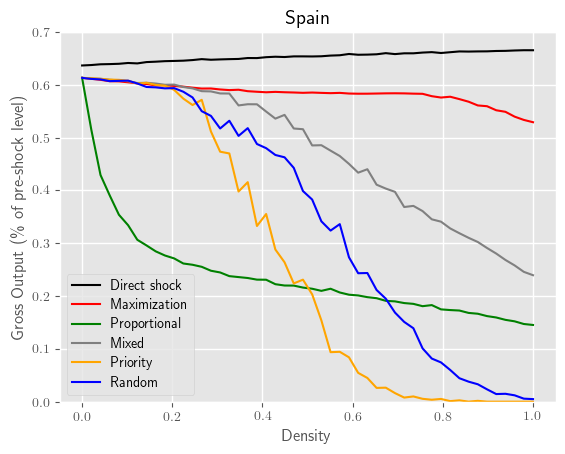

In [51]:
plt.style.use('ggplot')
plt.title("Spain")
plt.grid(visible=None, which='major', axis='both', linestyle='-', linewidth=1)

plt.plot(densseq, resdir_x, 'black')
plt.plot(densseq, resmax_x, 'red')
plt.plot(densseq, resprop_x, 'green')
plt.plot(densseq, resmixed_x, 'grey')
plt.plot(densseq, resprior_x, 'orange')
plt.plot(densseq, resrandom_x, 'blue')


#plt.xlim(-0.05, 1) 
plt.ylim(-0.00,0.7)
plt.rcParams['text.usetex'] = True
plt.xlabel('Density')
plt.ylabel('Gross Output (\% of pre-shock level)')
plt.legend(['Direct shock', 'Maximization', 'Proportional', 'Mixed', 'Priority', 'Random'])
plt.savefig('plot_esp_density_juist.png')